# Closed system simulations

In [1]:
include("notebook_preamble.jl")

First, we set up the spin-1/2 sites and Pauli operators.

In [2]:
b = SpinBasis(1//2)
I = identityoperator(b)
sx, sy, sz, sp, sm = sigmax(b), sigmay(b), sigmaz(b), sigmap(b), sigmam(b)
up, down = spinup(b), spindown(b)
ψx = eigenstates(dense(sx))[2][1]
tpow(x, n) = ⊗(repeat([x], n)...);

To create a $N$-site spin loop, we need to construct the basis for the loop and operators for each site.

In [3]:
N = 8
B = tpow(b, N)
site(i, op) = embed(B, (i-1)%N + 1, op); # Periodic boundary

We now construct the transverse-field Ising Hamiltonian
$$
\ham
= -\sum_{i=1}^N J_i \pauli_{zi} \pauli_{z(i+1)} - \sum_i h_i \pauli_{xi}
$$
We nondimensionalize time with $\tau = \omega t$, where $\omega = h / \hbar$.

In [4]:
Jh = 0.2
J = Jh*ones(N)
h = ones(N)
H = -sum(J[i]*site(i, sz)*site(i + 1, sz) + h[i]*site(i, sx) for i in 1:length(h));

The \term{magnetization} is
\begin{equation}\label{eq:magnetization}
\opr{M}
= \frac{1}{N} \sum_{i=1}^N \pauli_{zi}.
\end{equation}

In [5]:
M = (1/N) * sum(site(i, sz) for i in 1:N);

Now we time-evolve the system and look at the expectation values of some reduced operators. 

Since higher moments are present, the ribbons are only meant as rough guides to the variances.

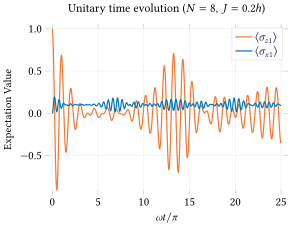

In [8]:
p = plot(xlabel="Time", ylabel="Expectation Values")
fout(t, ρ) = real([
        expect(sz, ptrace(ρ, [2:N;]))
        expect(sx, ptrace(ρ, [2:N;]))
        ])
for _ in 1:1
    ψ0 = tpow(up, N)
    # Interval to save results is more coarse than the solver step size.
    ts, fouts = timeevolution.schroedinger(π*[0:0.01:25;], ψ0, H, fout = fout)
    vals = hcat(fouts...)'
    plot!(ts / π, vals,
        title = latexstring("Unitary time evolution (\$N = $N\$, \$J = $Jh h\$)"),
        label = [L"\left\langle\sigma_{z1}\right\rangle" L"\left\langle\sigma_{x1}\right\rangle"],
        xlabel = L"\omega t / \pi",
        ylabel = "Expectation Value")
end
p

For comparison, the thermal state
$$
\dop
= \frac{\exp(-\beta\ham)}{\tr\exp(-\beta\ham)}
$$
has these expectations with temperature:

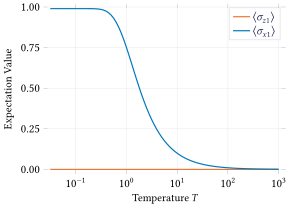

In [9]:
Ts = 10 .^ (-1.5:0.05:3)
plot(Ts, hcat((T -> fout(0, thermalstate(H, T))).(Ts)...)',
    label = [L"\left\langle\sigma_{z1}\right\rangle" L"\left\langle\sigma_{x1}\right\rangle"],
    xscale=:log10,
    xlabel=L"Temperature $T$",
    ylabel="Expectation Value")